# Семинар 2 - Цветовые пространства, гистограммы изображений, интегральные изображения

***

**Данный семинар содержит оцениваемые упражнения и вопросы.**

Система оценивания: доля правильно решенных упражений. Максимальный балл, соответственно, 1.

В упражнениях оценивается два аспекта:
1. Код проходит assert'ы (если они есть)
2. Код корректен с точки зрения логики

Вопросы также оцениваются. Ответ на них нужно записывать в соответствующие markdown-ячейки.

Источник используемого аэрофотоснимка: https://sovzond.ru/upload/medialibrary/267/%D0%98%D1%81%D1%85%D0%BE%D0%B4%D0%BD%D1%8B%D0%B9-%D0%B0%D1%8D%D1%80%D0%BE%D1%84%D0%BE%D1%82%D0%BE%D1%81%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA.jpg

In [1]:
from pathlib import Path

import cv2
import numpy as np

import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
AERIAL_IMG_PATH = "data/aerial_image.jpg"
SUNFLOWER_IMG_PATH = "data/sunflower.jpg"

if not Path(AERIAL_IMG_PATH).exists() or not Path(SUNFLOWER_IMG_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2023.git
    !mv cv_course_2023/seminars/seminar_02/data .

## 1. Цветовые пространства

Наиболее распространенным представлением цвета пикселя является пространство RGB. В таком представлении цвет представлен тремя числами: интенсивностями красного, зеленого и синего базисных цветов.

In [3]:
img = cv2.imread(SUNFLOWER_IMG_PATH)

In [4]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

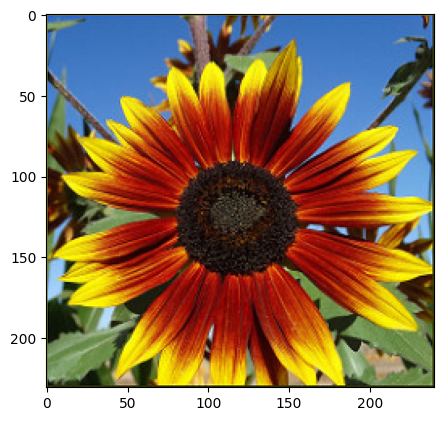

In [5]:
plt.figure(figsize=[5, 5])
plt.imshow(img_rgb)

cvtColor поддерживает конвертацию между множеством других цветовых схем. К примеру, чтобы получить серое изобаржение из цветного достаточно:

In [6]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

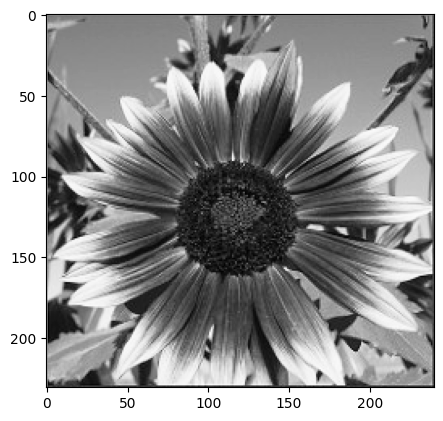

In [7]:
plt.figure(figsize=[5, 5])
plt.imshow(img_gray, cmap='Greys_r')

Если не предполагается использовать информацию о цвете пикселей, то можно сразу загрузить изображение в оттенках серого:

In [8]:
img_gray = cv2.imread(SUNFLOWER_IMG_PATH, cv2.IMREAD_GRAYSCALE)

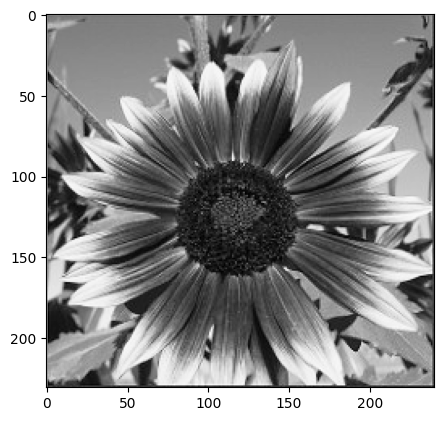

In [9]:
plt.figure(figsize=[5, 5])
plt.imshow(img_gray, cmap='Greys_r')

серое изображение - двумерный массив:

In [10]:
print('type(img_gray) = ', type(img_gray))
print('img_gray.shape = ', img_gray.shape)
print('img_gray.dtype = ', img_gray.dtype)

type(img_gray) =  <class 'numpy.ndarray'>
img_gray.shape =  (231, 240)
img_gray.dtype =  uint8


## Упражнение 1: RGB $\to$ gray

**Это и все последующие упражения - оцениваемые, для самостоятельной работы.**

Реализуйте функцию преобразования цветного изображения в формате RGB в серое

In [15]:
def convert_rgb_to_grayscale(img_rgb):
    consts = np.array([0.29901, 0.58701, 0.114])
    img_gray = img_rgb[..., :3] @ consts
    return np.round(img_gray).astype(np.uint8)

In [18]:
assert((cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY) == convert_rgb_to_grayscale(img_rgb)).all())

## Вопрос 1

**Этот и все последующие вопросы - оцениваемые, для самостоятельной работы.**

Почему бы не использовать при преобразовании в серое просто среднее арифметическое?

**Ответ:** Человеческий глаз по разному реагирует и воспринимает цвета разных диапазонов частот. Весовые коэф учитывают вклад каждого цвета в реакцию глаза целовека.

Кроме RGB/BGR и grayscale существуют и другие цветовые представления. Преобразования между ними можно осуществлять с помощью библиотеки OpenCV следующим способом:

## RGB $\to$ HSV

In [19]:
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

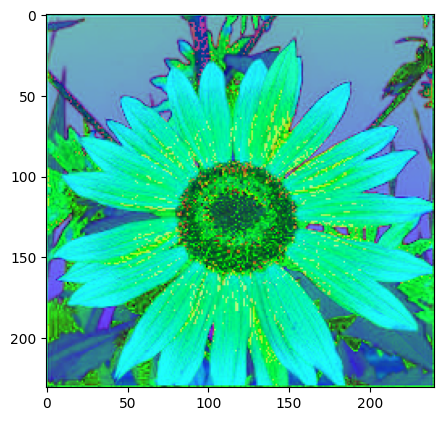

In [20]:
plt.figure(figsize=[5, 5])
plt.imshow(img_hsv)

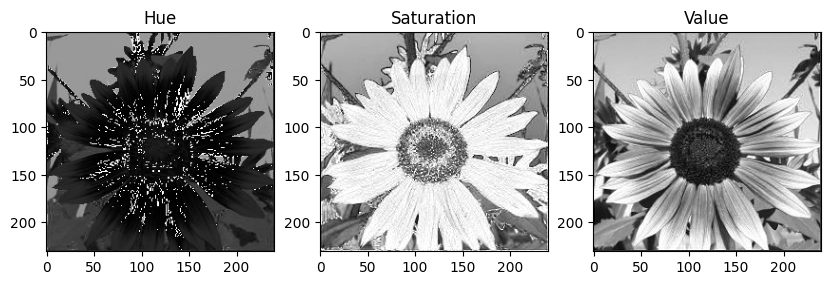

In [21]:
# Split the image into color channels
h, s, v = cv2.split(img_hsv)

plt.figure(figsize=[10, 30])
plt.subplot(131)
plt.imshow(h, cmap="gray")
plt.title('Hue')

plt.subplot(132)
plt.imshow(s, cmap="gray")
plt.title('Saturation')

plt.subplot(133)
plt.imshow(v, cmap="gray")
plt.title('Value')

# Display the plot
plt.show()


## Упражнение 2

Попробуйте другие цветовые пространства, конвертация в которые реализована в OpenCV.

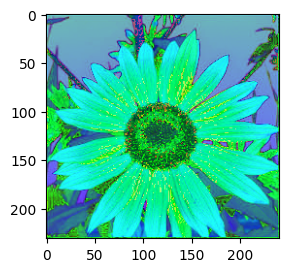

In [23]:
img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
plt.figure(figsize=(3, 3))
plt.imshow(img_hls)

## Вопрос 2

В каких задачах переход из RGB в другое цветовое пространство может быть полезным?

**Ответ:** Цветовой корекции, выделения объектов, визуализации, более глубокого и детального анализа имеющихся изображений, поиска схожих изображений

## Гистограмма изображения

Напомним, что гистограммой изображения называется функция, показыващая количество пикселей изображения с заданным в качестве аргумента значением интенсивности:

$$
    h(v) = \sum_{x = 0}^{W - 1} \sum_{y = 0}^{H - 1} [f(x, y) = v] 
$$

Если дополнительно потребовать, чтобы $\sum_{v = 0}^{255} h(v) = 1$, то $h$ будет представлять функцию плотности распределения интенсивности на изображении.

Определим вспомогательную функцию, позволяющую визализировать гистограмму:

In [24]:
def visualize_hist(hist):
    plt.figure(figsize=[20, 5])
    plt.bar(np.arange(len(hist)), hist / hist.sum())

Рассчитать гистограмму можно с помощью встроенной функции OpenCV:

In [25]:
hist_cv = cv2.calcHist([img_gray],      # список изображений
                       [0],             # список каналов
                       None,            # маска (без маски)
                       [256],           # размер гистограммы
                       [0, 256])[:, 0]  # диапазон значений

Результат представляет собой обычный массив длины 256:

In [26]:
print('hist_cv.shape = ', hist_cv.shape)

hist_cv.shape =  (256,)


и выглядит следующим образом:

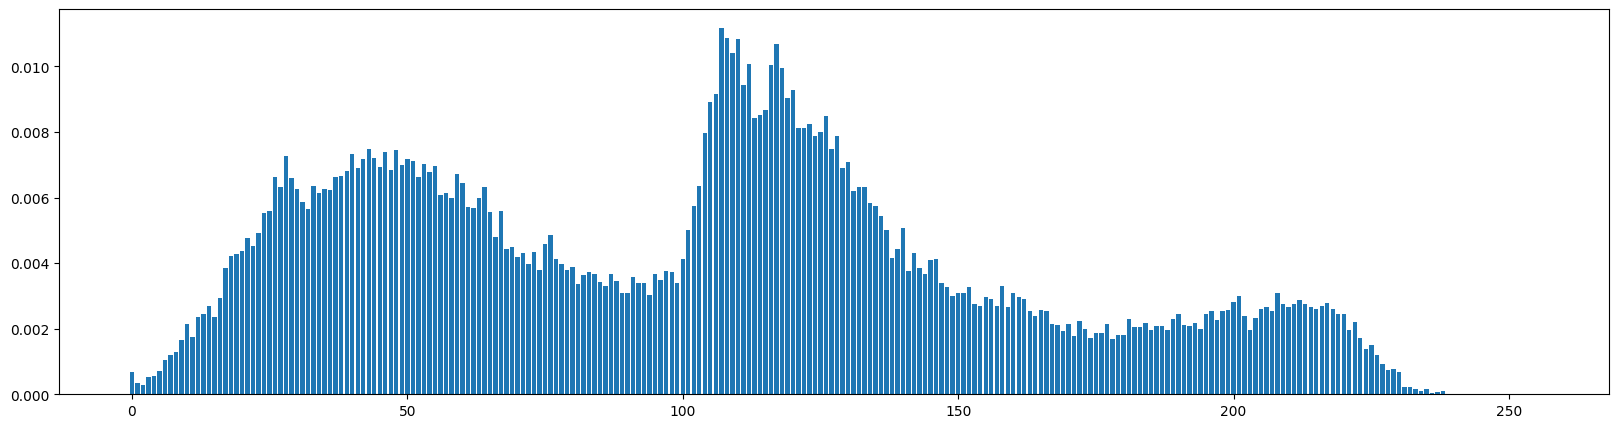

In [27]:
visualize_hist(hist_cv)

## Упражнение 3: Построение гистограммы

Реализуйте функцию для расчета гистограммы изображения. Используйте ее для визуализации трех каналов RGB изображения.

In [45]:
def compute_hist(img):
    hist = np.zeros(256)
    for px in img.flatten():
        hist[px] += 1
    return hist

In [46]:
hist_gray = compute_hist(img_gray)

hist_r = compute_hist(img_rgb[:, :, 0])
hist_g = compute_hist(img_rgb[:, :, 1])
hist_b = compute_hist(img_rgb[:, :, 2])

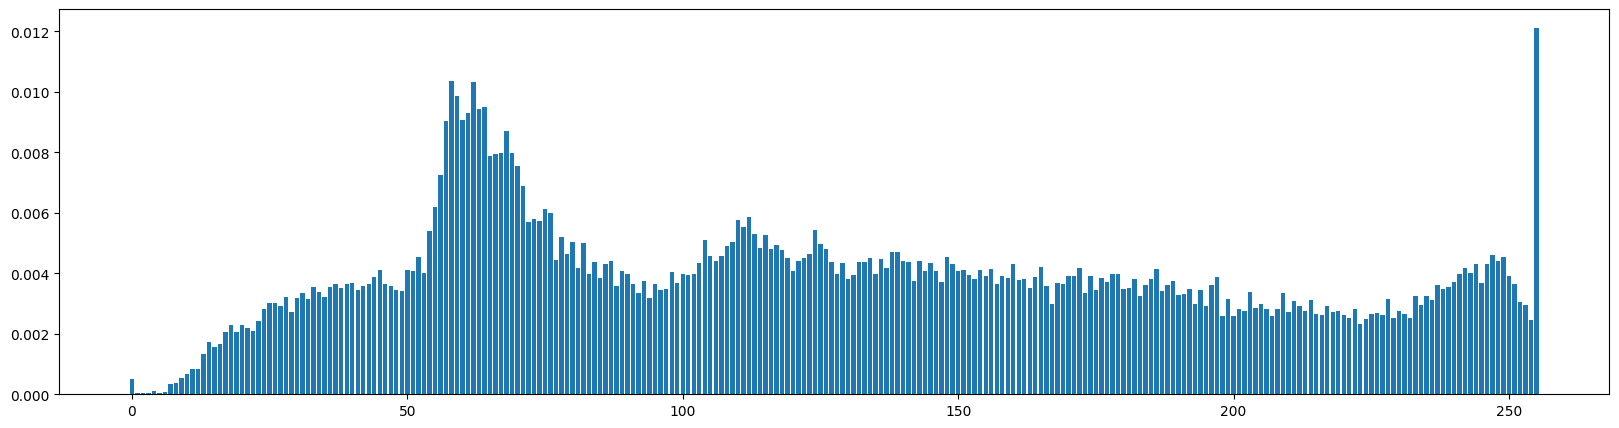

In [47]:
visualize_hist(hist_r)

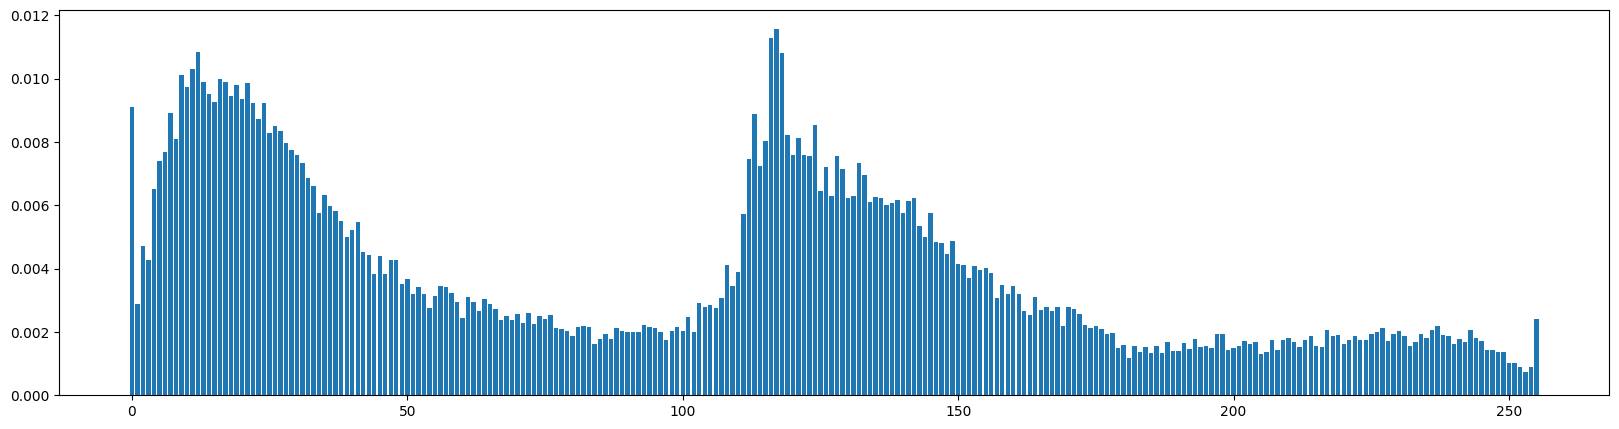

In [48]:
visualize_hist(hist_g)

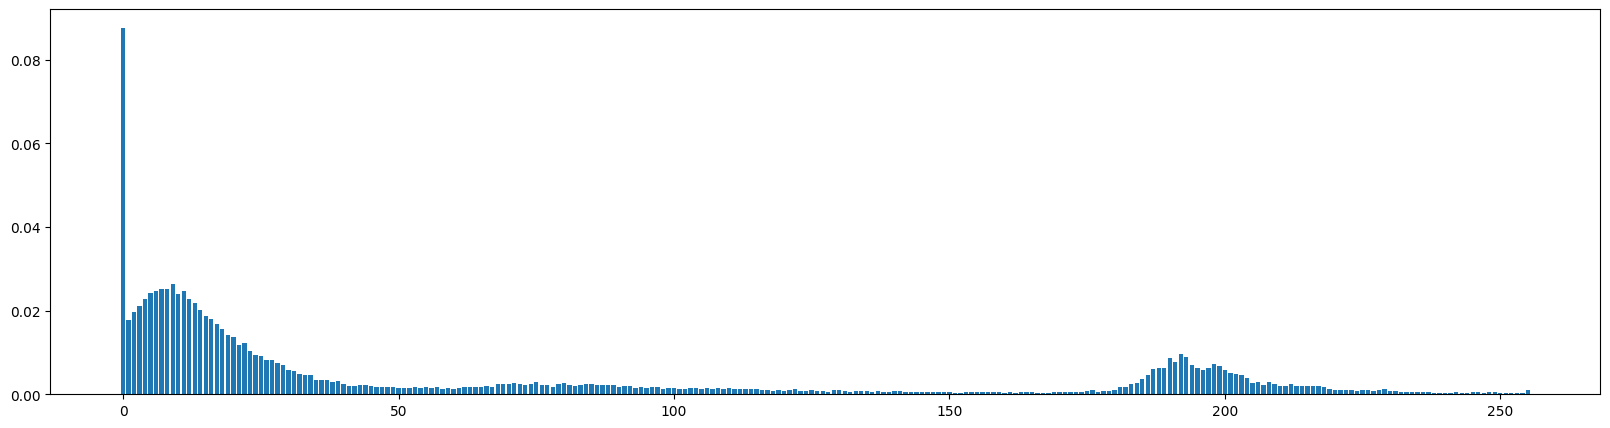

In [49]:
visualize_hist(hist_b)

In [50]:
assert((hist_gray == hist_cv).all())

## Вопрос 3

 Что можно сказать об изображении по его гистограмме?

**Ответ:** Какие на нем есть объекты, какая яркость, насколько оно шумное.

## Вопрос 4

Допустим, вы смотрите некоторый фильм и для текущего кадра выводите его гистограмму. Как будет меняться эта гистограмма с течением времени?

**Ответ:** В участках без смены кадра гистограмма будет изменяться медленно. 

## Упражнение 4: JPEG и гистограмма

Исследуйте, как влияет степень сжатия алгоритма JPEG на вид гистограммы изображения.

Используйте черно-белое изображение `img_gray`. Визуализируйте степени сжатия 90, 60, 30, 5.

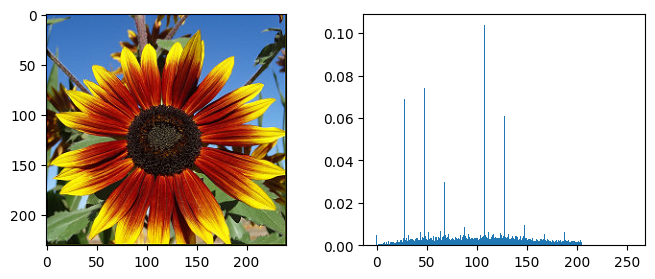

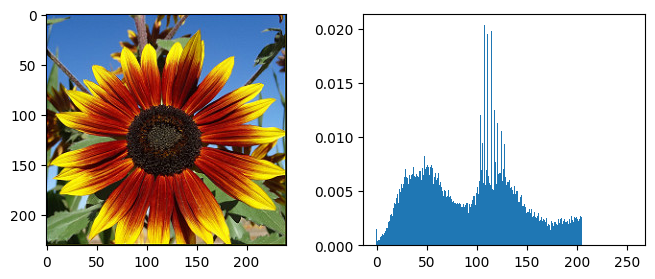

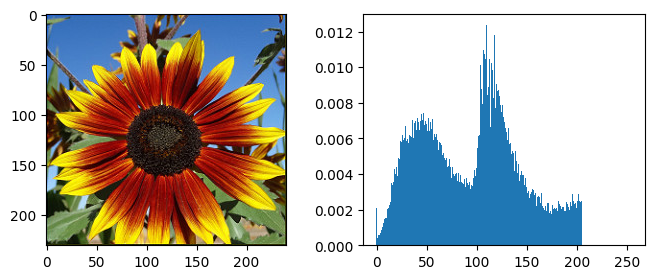

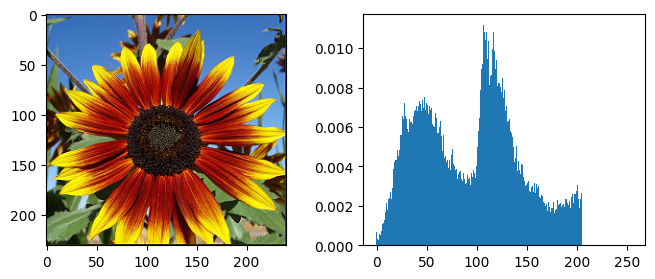

In [52]:
for i, val in enumerate([5, 30, 60, 90]):
    _, img_jpg = cv2.imencode('.jpg', img_gray, (cv2.IMWRITE_JPEG_QUALITY, val))
    img_dec = cv2.imdecode(img_jpg, cv2.IMREAD_COLOR)
    img_hist = compute_hist(img_dec[:,:,0])

    fig, ax = plt.subplots(1, 2, figsize=[8, 3])
    ax[0].imshow(img_rgb)
    ax[1].bar(np.arange(len(img_hist)), img_hist / img_hist.sum())
    plt.show()

## Упражнение 5: Сегментация

На загруженном аэроортофотоплане выделите зеленые насаждения. Для этого постройте бинарную маску, где 1 будет отвечать наличию насаждений в данном пикселе, 0 - их отсутствию, и визуализируйте её. А также рассчитайте, какую долю изображения занимают зеленые насаждения. С какой ошибкой (погрешностью) получена эта величина?

Подсказка: вам должно помочь HSV пространство и гистограмма. Погрешность может быть оценена на глаз, по вашей неуверенности в определении порога отделения классов 'зеленые насаждения'/'прочее'.

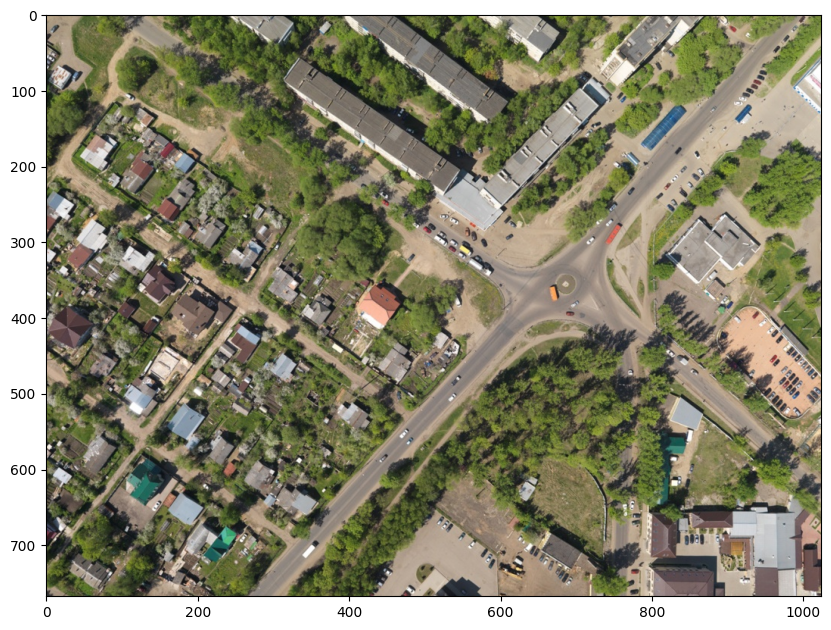

In [83]:
aerial_image = cv2.cvtColor(cv2.imread(AERIAL_IMG_PATH), cv2.COLOR_BGR2RGB)

plt.figure(figsize=[10, 10])
plt.imshow(aerial_image)

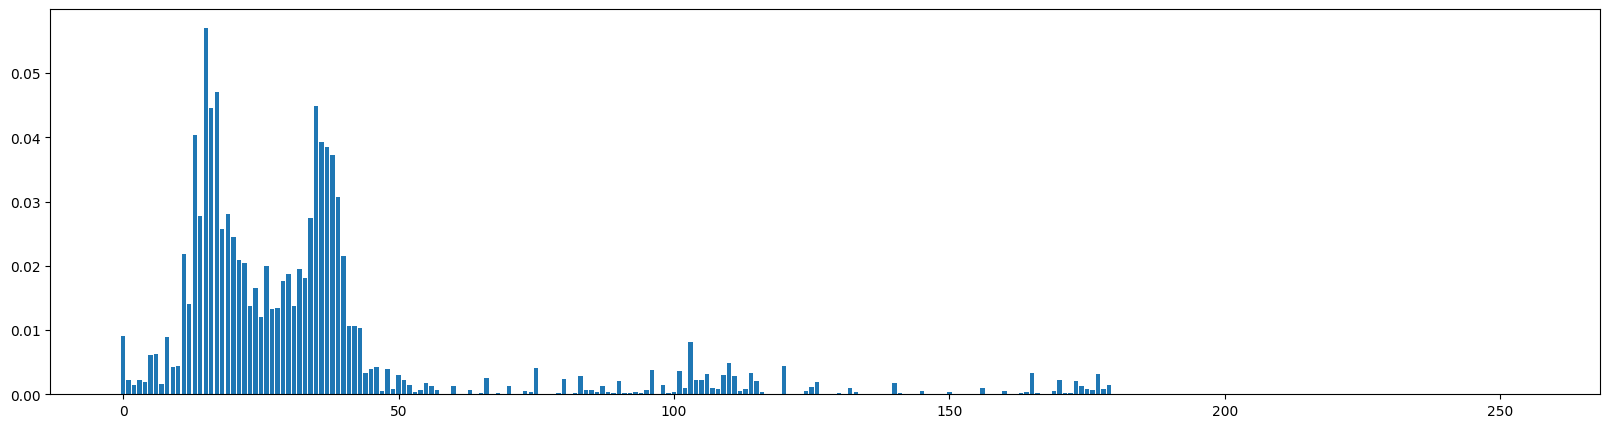

In [84]:
img_hsv = cv2.cvtColor(aerial_image, cv2.COLOR_RGB2HSV)
visualize_hist(compute_hist(img_hsv[..., 0]))

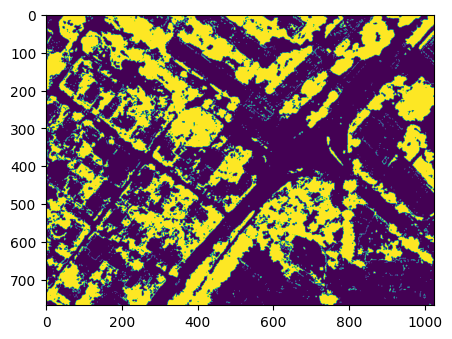

In [85]:
low = np.array([30, 0, 0])
up = np.array([50, 255, 255])
mask = cv2.inRange(img_hsv, low, up)
mask[mask == 255] = 1
plt.figure(figsize=[5, 5])
plt.imshow(mask)
pass

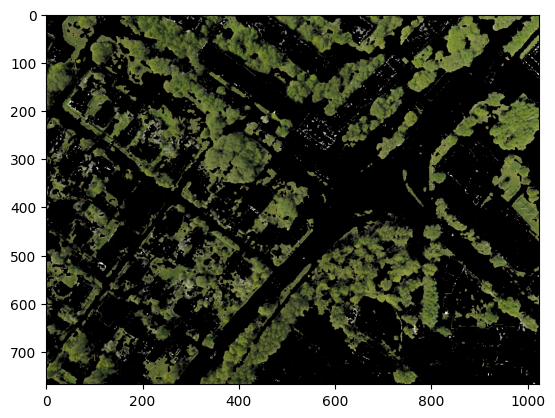

In [88]:
masked = aerial_image.copy()
masked[mask == 0] = (0, 0, 0)
plt.imshow(masked)

In [89]:
total = aerial_image.shape[0] * aerial_image.shape[1]
green = np.count_nonzero(mask)
print("Доля зеленых пикслей:", green / total)

Доля зеленых пикслей: 0.3610127766927083


# Упражнение 6: Интегральное изображение
Напомним, что интегральным изображением называется следующая функция:
$$
    I(x, y) = \sum_{i = 0}^{x} \sum_{j = 0}^{y} f(i, j)
$$
С помощью интегрального изображения можно за $O(1)$ вычислять сумму интенсивностей в произвольной прямоугольной области. Требуется реализовать расчет интегрального изображения, а также быстрый расчет сумм интенсивностей в прямоугольнике заданном верхним левым углом, шириной и высотой $x, y, w, h$.

In [90]:
class IntegralImage:
    def __init__(self, img):
        assert len(img.shape) == 2, "Only for grayscale images"
        self.img = img
        self.intensity = np.cumsum(np.cumsum(img, axis=0), axis=1).astype('int')

    def sum(self, x, y, w, h):
        A = self.intensity[y - 1, x - 1] if x > 0 and y > 0 else 0
        B = self.intensity[y - 1, x + w - 1] if y > 0 else 0
        C = self.intensity[y + h - 1, x - 1] if x > 0 else 0
        D = self.intensity[y + h - 1, x + w - 1]
        res = D - B - C + A
        return res

In [91]:
I = IntegralImage(img_gray)

In [92]:
x, y, w, h = 0, 0, 100, 100
assert(img_gray[y:y + h, x:x + w].sum() == I.sum(x, y, w, h))

x, y, w, h = 100, 100, 100, 100
assert(img_gray[y:y + h, x:x + w].sum() == I.sum(x, y, w, h))

## Вопрос 5

В каких задачах может потребоваться использовать интегральное изображение?

**Ответ:** Детекция, выделение признаков

## Вопрос 6

Какому методу решения задачи в программировании следует метод расчета интегрального изображения?

**Ответ:** Динамическое программирование
